In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.io as sio
import h5py
import scipy.signal as scisig
import importlib
import analysis_utils as au
import cmath

In [86]:
filename = r'D:\Lab Data\lorentz_force\sphere20250507\20250526\12.5 V\pos0 10\tt0.hdf5'
data, attrs = au.load_data_lf(filename)
PSD = scisig.welch(data['channel_d'][:10**7], fs = 1/attrs['delta_t'], nperseg = int(1/attrs['delta_t']))
fft = np.fft.fft(data['channel_d'][:10**5])

In [87]:
cal = 10**(-15)*0.75 # Matching to Yu-Han's calibration
print(np.sqrt(PSD[1][5500]*cal)/np.abs(fft[5500]))
cal2 = np.sqrt(PSD[1][5500]*cal)/np.abs(fft[5500])
print(np.abs(fft[5500]) * cal2)

6.927679343190049e-17
2.7548211220389303e-13


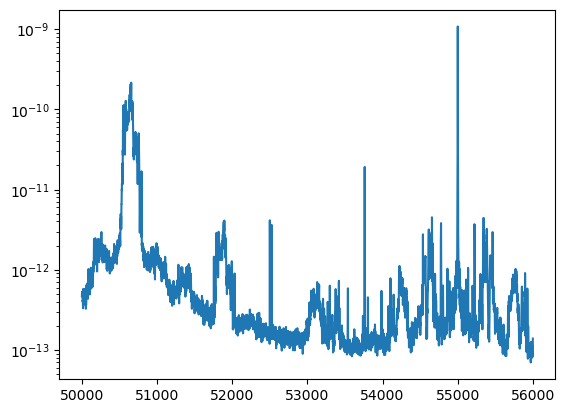

In [90]:
lb = 50000
ub = 56000
plt.plot(PSD[0][lb:ub], np.sqrt(PSD[1][lb:ub]*cal))
#plt.plot(PSD[0][lb:ub], np.abs(fft[lb:ub])*cal2)
plt.yscale('log')

In [4]:
freqs = [5500]
numfiles = 10
int_n = 10**5
file_n = 10**7
samples_per_file = int(file_n/int_n)
positions = [0, 1, 2]
cycles = np.linspace(0, 9, 10, dtype = int)
directions = [1, 2]

phases_pos = np.zeros((len(cycles), len(directions), len(positions), len(freqs), int(numfiles*samples_per_file)))
amps_pos = np.zeros((len(cycles), len(directions), len(positions), len(freqs), int(numfiles*samples_per_file)))
cfs_pos = np.zeros((len(cycles), len(directions), len(positions), len(freqs), int(numfiles*samples_per_file)))

for cycle in cycles:
    for direction in directions:
        for position in positions:
            path = r'D:\Lab Data\lorentz_force\sphere20250507\20250526\12.5 V\pos'+str(position)+' '+str(direction)+str(cycle)+r'\tt'
            files = np.linspace(0, numfiles-1, numfiles, dtype = int)
            end = '.hdf5'
            phases2 = np.zeros((len(freqs), int(numfiles*samples_per_file)))
            amps2 = np.zeros((len(freqs), int(numfiles*samples_per_file)))
            cf2 = np.zeros((len(freqs), int(numfiles*samples_per_file)))
            for n, file in enumerate(files):
                filename = path + str(file) + end
                data, attrs = au.load_data_lf(filename)
                for i in range(samples_per_file):
                    drive = data['channel_f'][i*int_n:(i+1)*int_n]
                    drive2 = data['channel_d'][i*int_n:(i+1)*int_n]
                    fft_drive = np.fft.rfft(drive)
                    fft_drive2 = np.fft.rfft(drive2)
                    for m, freq in enumerate(freqs):
                        phase = np.unwrap([-np.pi, cmath.phase(fft_drive[freq])-cmath.phase(fft_drive2[freq])])
                        amp = np.abs(fft_drive2[freq])/np.abs(fft_drive[freq])
                        cf = np.argmax(np.abs(fft_drive2[4800:5200]))*10+48000
                        amps2[m, samples_per_file*n+i] = amp
                        phases2[m, samples_per_file*n+i] = phase[1]
                        cf2[m, samples_per_file*n+i] = cf
            phases_pos[cycle, direction-1, position] = phases2
            amps_pos[cycle, direction-1, position] = amps2
            cfs_pos[cycle, direction-1, position] = cf2

In [5]:
data_dict = {'amps': amps_pos, 'phases': phases_pos, 'cfs': cfs_pos}
filename = r'C:\Users\thoma\Documents\SIMPLE\Data\Lab data\Lorentz force\Magsweep250526.hdf5'
au.save_data_hdf5(filename, data_dict)

In [6]:
data = au.load_data_hdf52(filename)
amps_pos = data['amps']
phases_pos = data['phases']
cfs_pos = data['cfs']

In [68]:
cal3 = 3.995255014561149e-10/amps_pos[0, 0, 0, 0, 0]
print(cal3)

3.1825020700030454e-10


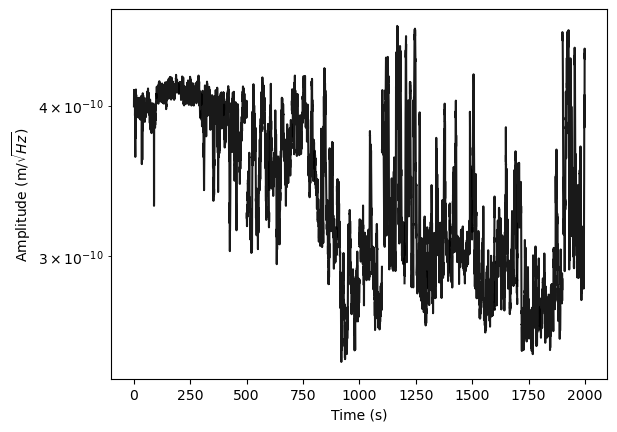

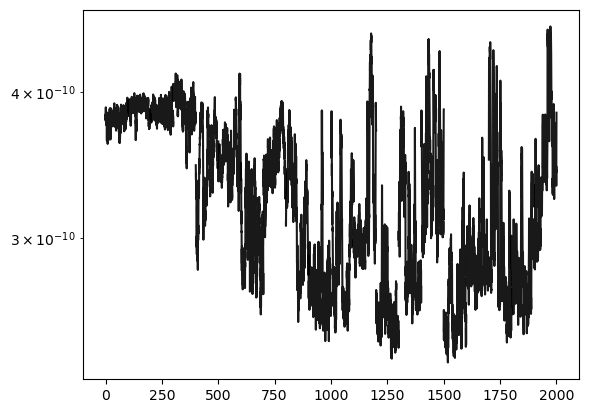

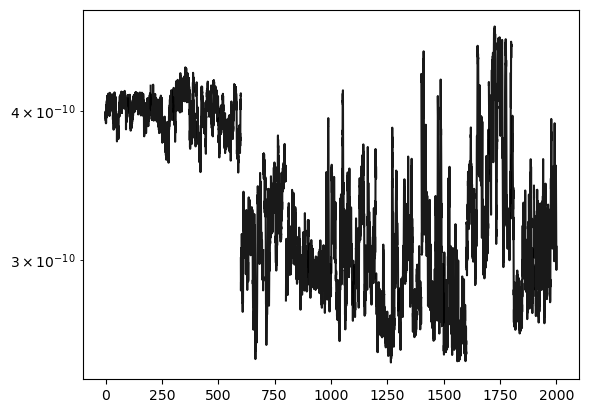

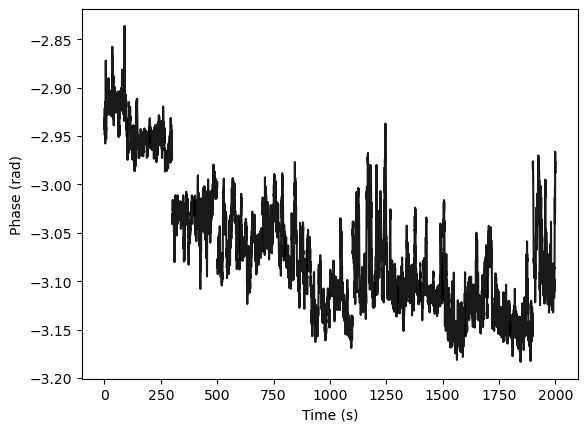

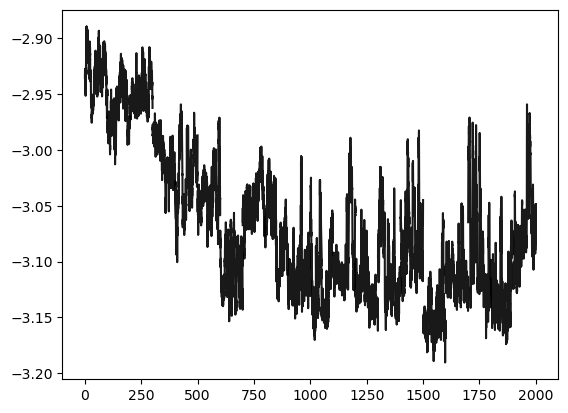

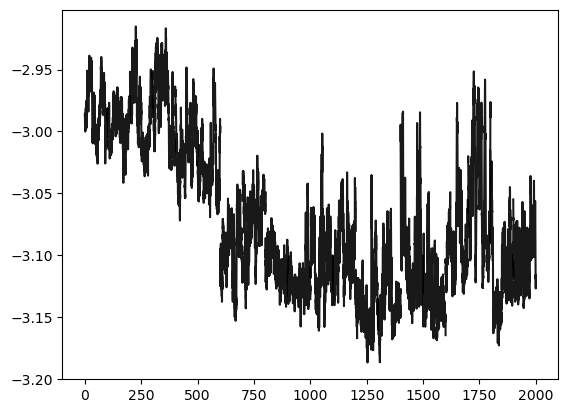

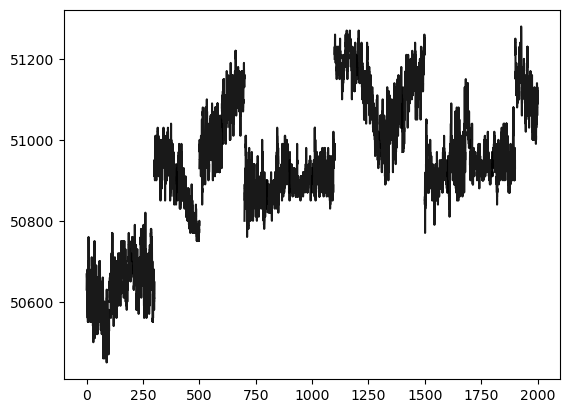

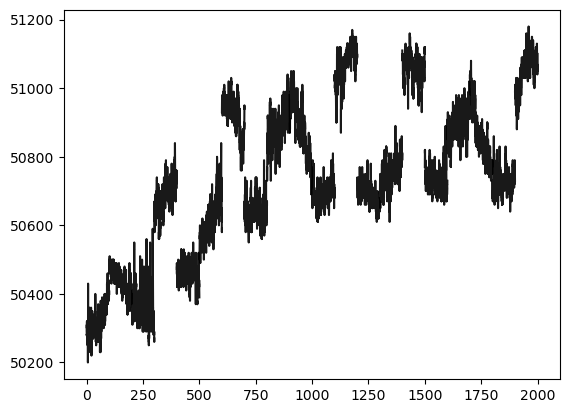

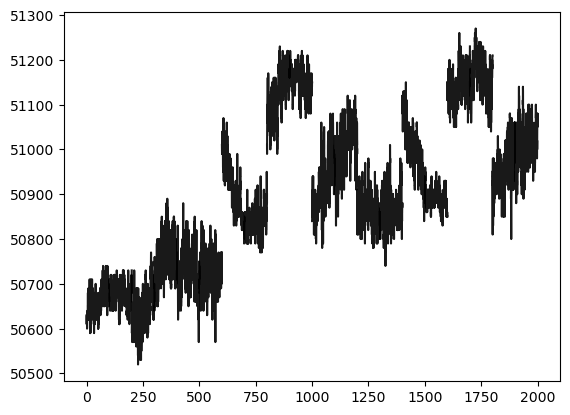

In [82]:
for m, i in enumerate(amps_pos[:,:, 0, 0].reshape((20, 1000))[:]):
    plt.plot(np.linspace(0, 99.9, 1000)+100*m, i*cal3, 'k', alpha = 0.9)
plt.yscale('log')
plt.ylabel('Amplitude (m/$\sqrt{Hz}$)')
plt.xlabel('Time (s)')
plt.figure()
for m, i in enumerate(amps_pos[:,:, 1, 0].reshape((20, 1000))):
    plt.plot(np.linspace(0, 100, 1000)+100*m, i*cal3, 'k', alpha = 0.9)
plt.yscale('log')
plt.figure()
for m, i in enumerate(amps_pos[:,:, 2, 0].reshape((20, 1000))):
    plt.plot(np.linspace(0, 100, 1000)+100*m, i*cal3, 'k', alpha = 0.9)
plt.yscale('log')

plt.figure()
for m, i in enumerate(phases_pos[:,:, 0, 0].reshape((20, 1000)[:])):
    plt.plot(np.linspace(0, 99.9, 1000)+100*m, i, 'k', alpha = 0.9)
plt.ylabel('Phase (rad)')
plt.xlabel('Time (s)')
plt.figure()
for m, i in enumerate(phases_pos[:,:, 1, 0].reshape((20, 1000))):
    plt.plot(np.linspace(0, 100, 1000)+100*m, i, 'k', alpha = 0.9)
plt.figure()
for m, i in enumerate(phases_pos[:,:, 2, 0].reshape((20, 1000))):
    plt.plot(np.linspace(0, 100, 1000)+100*m, i, 'k', alpha = 0.9)

plt.figure()
for m, i in enumerate(cfs_pos[:,:, 0, 0].reshape((20, 1000)[:])):
    plt.plot(np.linspace(0, 99.9, 1000)+100*m, i, 'k', alpha = 0.9)
plt.figure()
for m, i in enumerate(cfs_pos[:,:, 1, 0].reshape((20, 1000))):
    plt.plot(np.linspace(0, 100, 1000)+100*m, i, 'k', alpha = 0.9)
plt.figure()
for m, i in enumerate(cfs_pos[:,:, 2, 0].reshape((20, 1000))):
    plt.plot(np.linspace(0, 100, 1000)+100*m, i, 'k', alpha = 0.9)


In [ ]:
cf_rs = cfs_pos[:,:, 0, 0].reshape((20000))
amp_rs = amps_pos[:,:, 0, 0].reshape((20000))

cf_rs2 = cfs_pos[:,:, 1, 0].reshape((20000))
amp_rs2 = amps_pos[:,:, 1, 0].reshape((20000))

cf_rs3 = cfs_pos[:,:, 2, 0].reshape((20000))
amp_rs3 = amps_pos[:,:, 2, 0].reshape((20000))

In [47]:
amp_mean1 = np.mean(cal3*amp_rs)
amp_std1 = np.std(cal3*amp_rs)/np.sqrt(len(amp_rs[:37000]))
print(amp_mean1, amp_std1)

amp_mean12 = np.mean(cal3*amp_rs*np.abs((cf_rs**2 - 55000**2))/np.abs((cf_rs[0]**2 - 55000**2)))
amp_std12 = np.std(cal3*amp_rs*np.abs((cf_rs**2 - 55000**2))/np.abs((cf_rs[0]**2 - 55000**2)))/np.sqrt(len(amp_rs))
print(amp_mean12, amp_std12)

amp_mean2 = np.mean(cal3*amp_rs2[:37000])
amp_std2 = np.std(cal3*amp_rs2[:37000])/np.sqrt(len(amp_rs2[:37000]))
print(amp_mean2, amp_std2)

amp_mean22 = np.mean(cal3*amp_rs2[:37000]*np.abs((cf_rs2[:37000]**2 - 55000**2))/np.abs((cf_rs2[0]**2 - 55000**2)))
amp_std22 = np.std(cal3*amp_rs2[:37000]*np.abs((cf_rs2[:37000]**2 - 55000**2))/np.abs((cf_rs2[0]**2 - 55000**2)))/np.sqrt(len(amp_rs2[:37000]))
print(amp_mean22, amp_std22)

amp_mean3 = np.mean(cal3*amp_rs3[:37000])
amp_std3 = np.std(cal3*amp_rs3[:37000])/np.sqrt(len(amp_rs3[:37000]))
print(amp_mean3, amp_std3)

amp_mean32 = np.mean(cal3*amp_rs3[:37000]*np.abs((cf_rs3[:37000]**2 - 55000**2))/np.abs((cf_rs3[0]**2 - 55000**2)))
amp_std32 = np.std(cal3*amp_rs3[:37000]*np.abs((cf_rs3[:37000]**2 - 55000**2))/np.abs((cf_rs3[0]**2 - 55000**2)))/np.sqrt(len(amp_rs3[:37000]))
print(amp_mean32, amp_std32)

3.412441183614982e-10 3.7017759334300696e-13
3.1871406796035636e-10 3.867706209734406e-13
3.25780985481521e-10 3.4937167255614614e-13
2.9608173203123203e-10 3.686693296174672e-13
3.3778522981086715e-10 3.789464350353982e-13
3.183436695989646e-10 4.0743102550273265e-13


Text(0, 0.5, 'Amplitude (m/$\\sqrt{Hz}$)')

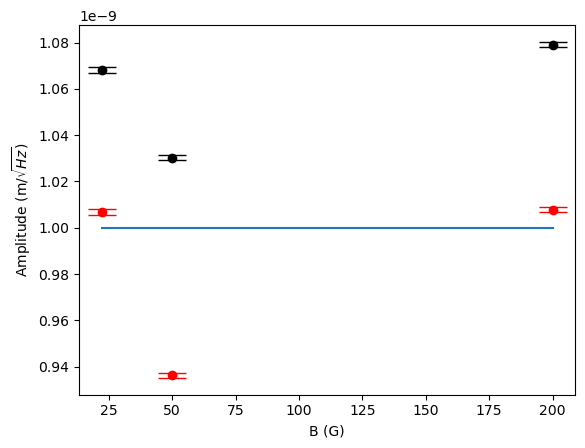

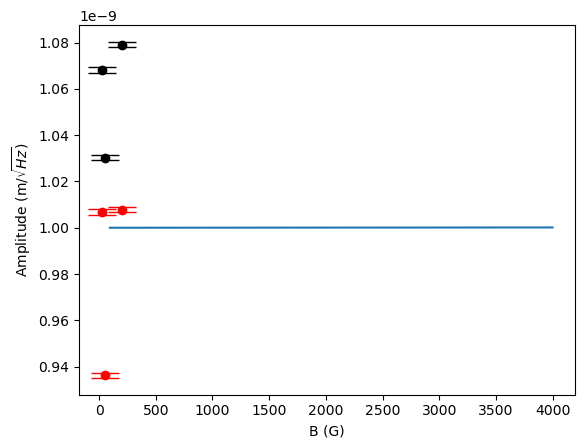

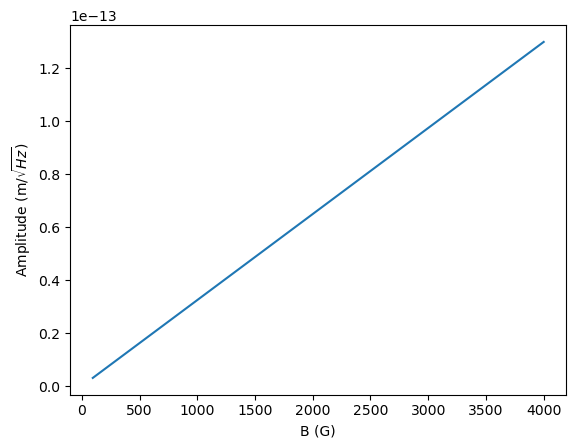

In [74]:
B = 200*np.array([1, (8/16)**2, (8/24)**2])
B2 = 200*np.linspace(1, (8/24)**2, 1000)

m1 = np.array([amp_mean1, amp_mean2, amp_mean3])
s1 = np.array([amp_std1, amp_std2, amp_std3])

m2 = np.array([amp_mean12, amp_mean22, amp_mean32])
s2 = np.array([amp_std12, amp_std22, amp_std32])

plt.errorbar(B, m1*np.sqrt(10), yerr = s1*np.sqrt(10), color = 'k', marker = 'o', linestyle = 'None', capsize = 10, label = 'Uncorrected')
plt.errorbar(B, m2*np.sqrt(10), yerr = s2*np.sqrt(10), color = 'r', marker = 'o', linestyle = 'None', capsize = 10, label = 'Corrected')
plt.plot(B2, 1*10**(-9)+B2*0.7*10**(-14)/200)
plt.xlabel('B (G)')
plt.ylabel('Amplitude (m/$\sqrt{Hz}$)')

B3 = 4000*np.linspace(1, (3.7/24)**2, 1000)

plt.figure()
plt.errorbar(B, m1*np.sqrt(10), yerr = s1*np.sqrt(10), color = 'k', marker = 'o', linestyle = 'None', capsize = 10, label = 'Uncorrected')
plt.errorbar(B, m2*np.sqrt(10), yerr = s2*np.sqrt(10), color = 'r', marker = 'o', linestyle = 'None', capsize = 10, label = 'Corrected')
plt.plot(B3, 1*10**(-9)+B3*1.3*10**(-13)/4000)
plt.xlabel('B (G)')
plt.ylabel('Amplitude (m/$\sqrt{Hz}$)')

plt.figure()
plt.plot(B3, B3*1.3*10**(-13)/4000)
plt.xlabel('B (G)')
plt.ylabel('Amplitude (m/$\sqrt{Hz}$)')

In [55]:
phase_rs = phases_pos[:,:, 0, 0].reshape((20000))
phase_rs2 = phases_pos[:,:, 1, 0].reshape((20000))
phase_rs3 = phases_pos[:,:, 2, 0].reshape((20000))

In [78]:
lb = 10000
ub = -1
print(np.mean(phase_rs[lb:ub]), np.std(phase_rs[lb:ub])/np.sqrt(len(phase_rs[lb:ub])))
print(np.mean(phase_rs2[lb:ub]), np.std(phase_rs2[lb:ub])/np.sqrt(len(phase_rs2[lb:ub])))
print(np.mean(phase_rs3[lb:ub]), np.std(phase_rs3[lb:ub])/np.sqrt(len(phase_rs3[lb:ub])))

-3.1072610374255936 0.00038707916580342283
-3.1054810214473063 0.0003913367489245549
-3.104810121913807 0.00039677043429568975


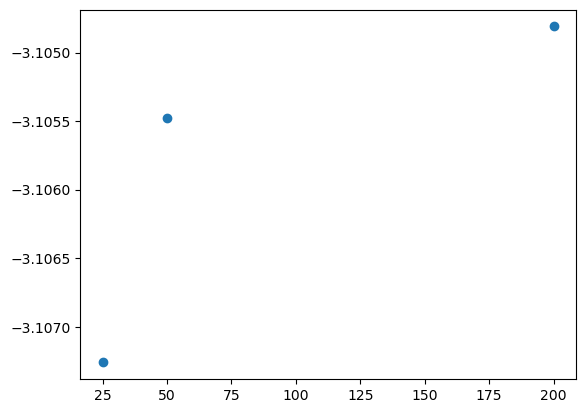

In [80]:
plt.plot([25, 50, 200], [-3.107261, -3.105481, -3.104810], 'o')

In [20]:
phase_rs_lp = au.butter_lowpass_filter(phase_rs, 0.001, 1, order = 3)
phase_rs_lp2 = au.butter_lowpass_filter(phase_rs2, 0.001, 1, order = 3)
phase_rs_lp3 = au.butter_lowpass_filter(phase_rs3, 0.001, 1, order = 3)

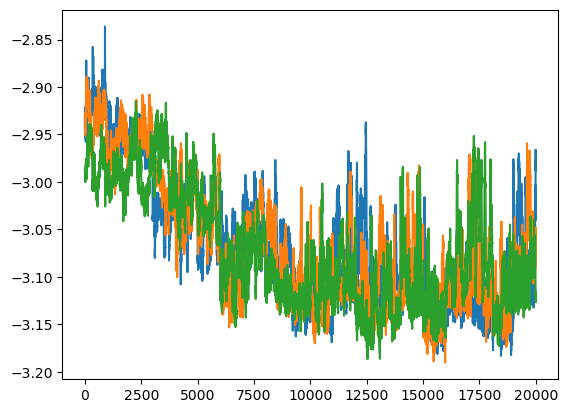

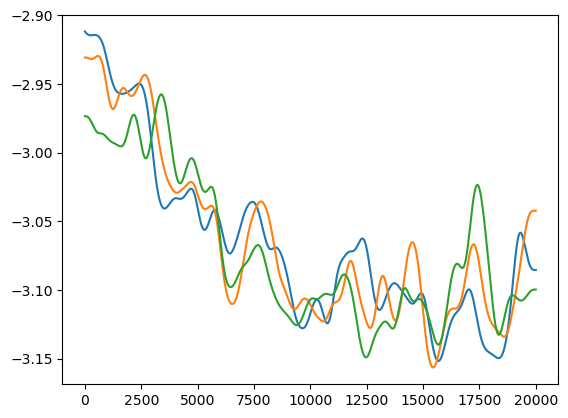

In [22]:
plt.plot(phase_rs)
plt.plot(phase_rs2)
plt.plot(phase_rs3)
plt.figure()
plt.plot(phase_rs_lp)
plt.plot(phase_rs_lp2)
plt.plot(phase_rs_lp3)